In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from exp.nb_Tesis import *
from fastai import *

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [18]:
!pip install efficientnet-pytorch


  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.1-cp37-none-any.whl size=12408 sha256=afb873fde3391620a4a520bee9652a340f677e5b85d4c6a3ea38fb23a5398a5f
  Stored in directory: /home/mike/.cache/pip/wheels/0f/b0/79/1663bc9714b5d88deba05e44f593ce50111bd69305a45df87a
Successfully built efficientnet-pytorch


# Download & Load Data

### Download

In [2]:
# !wget https://challenge.kitware.com/api/v1/item/584ad09dcad3a51cc66c8e15/download

In [3]:
# !wget https://challenge.kitware.com/api/v1/item/5849dadccad3a51cc66c8e08/download

In [4]:
# !wget https://challenge.kitware.com/api/v1/item/58a24018cad3a51804c44072/download

### Load

In [2]:
lession_to_train_for = 'melanoma' #melanoma or 'seborrheic_keratosis'

In [3]:
# 1
path_all_images = Path('./2017/data/')

# 2
# path_all_images = Path('/data2/mike/augmented_images/')

In [25]:
name_folder_train = 'ISIC-2017_Training_Data'
name_folder_valid = 'ISIC-2017_Validation_Data'

#1
# name_folder_train = 'train_small_256'
# name_folder_valid = 'valid_small_256'
# name_folder_test = 'test_small_256'


# # 2
# name_folder_train = 'training'
# name_folder_valid = 'validation'

# 3
name_folder_train = 'train_small_300'
name_folder_valid = 'valid_small_300'
# name_folder_test = 'test_small_256'



path_train_images = path_all_images / name_folder_train
path_valid_images = path_all_images / name_folder_valid
path_test_images = path_all_images / name_folder_test

In [26]:
path_train_ground_truth = Path('./2017/train_gt.csv')
path_valid_ground_truth = Path('./2017/valid_gt.csv')
path_test_ground_truth = Path('./2017/test_gt.csv')


In [27]:
dfTrain = pd.read_csv(path_train_ground_truth); print(f'{len(dfTrain)} train images: ')
dfValid = pd.read_csv(path_valid_ground_truth); print(f'{len(dfValid)} valid images: ')
dfTest = pd.read_csv(path_test_ground_truth); print(f'{len(dfTest)} test images: ')



dfAll = pd.concat([dfTrain,dfValid,dfTest])
dfSingleLabel = pd.DataFrame({'image_id':dfAll['image_id'] })
dfSingleLabel['label'] = pd.np.where(dfAll[lession_to_train_for]==1.0, lession_to_train_for,'other')

assert not any(dfSingleLabel.duplicated())

dfSingleLabel.head()

2000 train images: 
150 valid images: 
600 test images: 


,image_id,label
0,ISIC_0000000,other
1,ISIC_0000001,other
2,ISIC_0000002,melanoma
3,ISIC_0000003,other
4,ISIC_0000004,melanoma


In [28]:
dfSingleLabel.groupby('label').count()

,image_id
label,
melanoma,521
other,2229


In [29]:
import re

def remove_sample_number_from_name(image_name):
    return re.sub(r'_sample_\d+', '', image_name)

remove_sample_number_from_name('ISIC_0013196_sample_28')


def get_label_for_image_path(image_path):
    return list(dfSingleLabel.loc[dfSingleLabel['image_id']==remove_sample_number_from_name(image_path.name[:-4])].label)[0]


# Create Databunch

In [34]:
random_seed(42,True)
tfms = get_transforms(flip_vert=True, max_rotate=180, max_zoom=1.6, max_lighting=.3, p_affine=1, max_warp=0)
data = ImageList.from_folder(path_all_images)\
.split_by_folder(train=name_folder_train, valid=name_folder_valid)\
.label_from_func(get_label_for_image_path)\
.transform(tfms,size=300)\
.databunch(bs=16)\
.normalize()

In [31]:
# data.show_batch()
data.train_ds[0]

(Image (3, 300, 300), Category other)

In [32]:
train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

print(train_count,'\n\n', valid_count)
print('ratios:')
print(train_count['melanoma'] / train_count['other'], '%')
print(valid_count['melanoma'] / valid_count['other'], '%')

other       1626
melanoma     374
dtype: int64 

 other       120
melanoma     30
dtype: int64
ratios:
0.23001230012300122 %
0.25 %


In [78]:
# del learn
# del data

torch.cuda.empty_cache()
gc.collect()

4127

# Create Learner

### Efficientnet

In [35]:
from efficientnet_pytorch import EfficientNet

model_name = 'efficientnet-b3'
model = EfficientNet.from_pretrained(model_name)
model._fc = nn.Linear(1536, data.c) # si es b0 poner aca 1280

# x50 = lambda x: xresnet50()resnet14
learn = Learner(data,model, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ]               )

learn.summary()



Loaded pretrained weights for efficientnet-b3


EfficientNet
Layer (type)         Output Shape         Param #    Trainable 
ZeroPad2d            [3, 301, 301]        0          False     
______________________________________________________________________
BatchNorm2d          [40, 150, 150]       80         True      
______________________________________________________________________
ZeroPad2d            [40, 152, 152]       0          False     
______________________________________________________________________
BatchNorm2d          [40, 150, 150]       80         True      
______________________________________________________________________
Identity             [40, 1, 1]           0          False     
______________________________________________________________________
Identity             [10, 1, 1]           0          False     
______________________________________________________________________
Identity             [40, 150, 150]       0          False     
_________________________________________________

### Other nets

In [39]:
random_seed(7,True)
x50 = lambda x: xresnet50()
learn = cnn_learner(data,models.resnet50, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ], 
                    
                    pretrained=True
                    )

learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
Conv2d               [64, 32, 32]         36,864     False     
___________________________________________________

In [118]:
# learn.load('bestmodel')
# learn.lr_find()

## Train model's head

### Weighting the classes

In [64]:
weighted_classes = [{c: max(train_count) / train_count[c]} for c in data.classes];
print(weighted_classes)
formatted_weights = [w[c] for c,w in zip(data.classes, weighted_classes) ] 
print(formatted_weights)

class_weights=torch.FloatTensor(formatted_weights).cuda()
learn.loss_func = CrossEntropyFlat(weight = class_weights)

[{'melanoma': 4.347593582887701}, {'other': 1.0}]
[4.347593582887701, 1.0]


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.460803,0.431975,0.180000,0.820000,0.784167,00:50


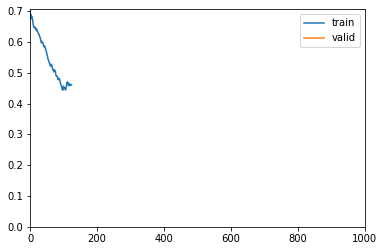

Better model found at epoch 0 with auroc value: 0.784166693687439.


In [ ]:
random_seed(7,True)

max_lr = slice(1e-3,1e-2)
wd = 1e-4
learn.fit_one_cycle(8,max_lr=1e-3,wd=wd, callbacks = [
    SaveModelCallback(learn=learn,monitor='auroc',name='auroc_'+model_name),
    CSVLogger(learn=learn,filename=model_name)
#     ReduceLROnPlateauCallback(learn=learn)
])

## Unfreeze & finetune

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1')

### Fit one cycle 

In [44]:
# learn.unfreeze()

# learn.lr_find()
# learn.recorder.plot(suggestion=True)

In [ ]:
learn.unfreeze()
random_seed(7,True)

learn.fit_one_cycle(10, max_lr=7e-6,callbacks = [
    SaveModelCallback(learn=learn,monitor='auroc',name="auroc_"+ model_name),
    CSVLogger(learn=learn,filename=model_name)
#     ReduceLROnPlateauCallback(learn=learn)
])

In [54]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [ ]:
learn.save("auroc_"+ model_name)

### Fit like paper

In [226]:
learn.data.classes

['melanoma', 'other']

In [40]:

learn.unfreeze()

random_seed(7,True)

paper_epochs = 100
paper_lr = 1e-4
epochs_to_preserve_lr=30
fit_like_paper(learn, paper_epochs, paper_lr,epochs_to_preserve_lr)

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time


KeyboardInterrupt: 

In [216]:
learn.load('with_attn_trained_like_paper_stop_at_best')

Learner(data=ImageDataBunch;

Train: LabelList (2000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
other,other,other,other,other
Path: 2017/data;

Valid: LabelList (600 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
other,other,other,other,other
Path: 2017/data/test_small_256;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [217]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

False

In [238]:
interp.losses.

tensor([1.1746e-01, 1.1871e-01, 2.4783e-01, 6.4033e-02, 1.1802e-01, 4.7482e-01,
        3.4065e-02, 5.8796e-02, 2.7901e-01, 9.6560e-02, 7.5273e-01, 2.3066e-01,
        4.9067e-01, 5.0268e-01, 1.9007e-02, 2.0220e-02, 1.0150e-01, 3.6190e+00,
        1.7496e+00, 7.5823e-02, 1.2567e-01, 1.1906e-01, 1.8354e-02, 1.9922e-01,
        3.7662e-03, 1.6429e-01, 9.0193e-01, 2.2907e-01, 1.2650e-01, 8.3442e-02,
        1.0028e-01, 4.3770e-01, 5.8474e-02, 1.7282e-01, 1.2652e-02, 9.4331e-01,
        3.2208e-01, 1.0687e-01, 5.4293e-01, 3.1963e-01, 1.6471e+00, 3.6921e-01,
        6.0331e-01, 4.3888e-01, 5.1024e-02, 1.6392e-01, 8.7883e-01, 1.8752e-01,
        9.8678e-02, 2.7689e-01, 2.0939e-01, 6.0332e-01, 2.5118e+00, 1.3494e-02,
        3.4145e+00, 4.4806e-02, 1.9824e-01, 2.2911e-03, 2.5635e-01, 6.3183e-01,
        1.0145e-01, 1.0153e-01, 2.5737e-02, 4.3370e-01, 4.1987e-01, 5.5859e-01,
        6.7883e-01, 4.6515e-01, 8.0311e-03, 1.2471e-02, 5.9873e-01, 4.4348e-02,
        5.5209e-01, 1.4242e-01, 2.0933e-

In [242]:
import fastai; fastai.__version__


'1.0.58'

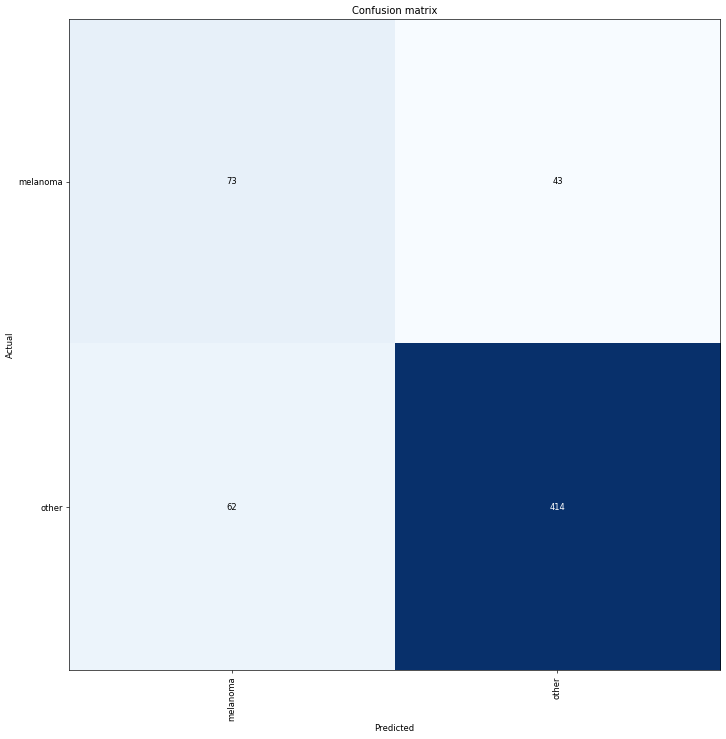

In [219]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
plt.autoscale()

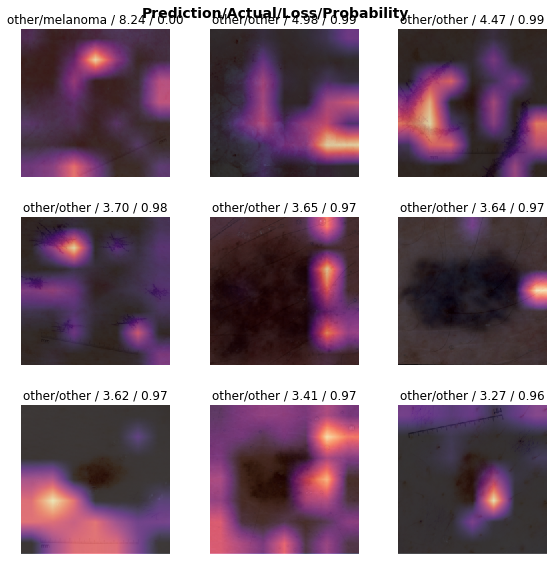

In [240]:
interp.plot_top_losses(9, figsize=(8,8),heatmap=True,alpha=.7)
plt.tight_layout()

In [94]:

def get_balanced_accurracy(a_confusion_matrix):
  balanced_acc = 0
  for i in range(len(matrix[0])):
    row = matrix[i]
    correctGuesses = row[i]
    allPossibleTries = row.sum()
    classAcurracy = correctGuesses / allPossibleTries
    balanced_acc += classAcurracy
#     print(classAcurracy)
  balanced_acc /= len(matrix[0])
  return balanced_acc



matrix = interp.confusion_matrix()
"average acc: ", get_balanced_accurracy(matrix)


('average acc: ', 0.6583333333333333)

# Attention

In [51]:
from fastai.vision import *

In [52]:
import types

from torchvision.models.resnet import Bottleneck

In [53]:
alpha_initial_value = 0.001 #OJO

In [54]:
def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

            
        out = out + (identity * self.softmaxLayer(out) * self.alpha) + (identity)

        out = self.relu(out)

        return out

def add_attn_to_forward_func(a_module):
    a_module.forward = types.MethodType( forward,a_module)
    
def add_attn_params(a_module):
    a_module.softmaxLayer = nn.Softmax2d();
    a_module.alpha = nn.Parameter(torch.ones(1) * alpha_initial_value)
#     print(f'Added attention to {a_module}')
    
    
def change_basic_blocks(a_module):
    if not isinstance(a_module, Bottleneck): return
    add_attn_params(a_module)
    add_attn_to_forward_func(a_module)

In [55]:
resnet50_with_attn = models.resnet50(pretrained=True)
apply_leaf(resnet50_with_attn, change_basic_blocks)

In [56]:
a = list(resnet50_with_attn.modules())[0]

bn = a.layer1[0]

# assert bn.alpha.item() == 0

In [57]:
ps = list(resnet50_with_attn.named_parameters())

ls = [n for n in ps if 'alpha' in n[0]]

len(ls)

16

In [58]:
def mock_arch_init(params): 
  return resnet50_with_attn

In [59]:
bottlenecks = [bn for bn in resnet50_with_attn.modules() if isinstance(bn,Bottleneck)]

In [60]:
class Alphas(ActivationStats):

    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return m.alpha.item(),m.alpha.item()
    

In [116]:
random_seed(7,True)
# x50 = lambda x: xresnet50()
learn = cnn_learner(data,mock_arch_init, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
#                             ActivationStats,
                            partial(Alphas, modules=bottlenecks),
                        partial(CSVLogger, filename="con_att",append=False)
                                  ], 
                    pretrained=True #Is pretrained so alpha dont require grand and net isnt reinitialized
                    )

In [ ]:
learn.model[0]

## Train freezed

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.141454,0.796564,0.186667,0.813333,0.685000,00:17
1,0.615271,0.580865,0.186667,0.813333,0.791944,00:17
2,0.516403,0.586867,0.213333,0.786667,0.626389,00:17
3,0.438433,0.410472,0.166667,0.833333,0.804444,00:17
4,0.397942,0.425330,0.173333,0.826667,0.803889,00:17


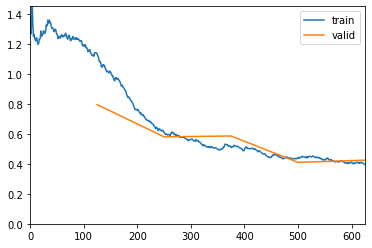

Better model found at epoch 0 with valid_loss value: 0.7965644598007202.
Better model found at epoch 1 with valid_loss value: 0.5808651447296143.
Better model found at epoch 3 with valid_loss value: 0.41047221422195435.


In [120]:
a = list(resnet50_with_attn.modules())[0]

bn = a.layer1[0]

assert not bn.alpha.requires_grad

random_seed(7,True)
learn.fit_one_cycle(5,max_lr=3e-3, callbacks = [
    SaveModelCallback(learn=learn),
#     ReduceLROnPlateauCallback(learn=learn)
])

In [129]:
learn.save('stage-1-with-attn')

In [ ]:
learn.load('stage-1-with-attn')

## Unfreeze and train with attention

### Fit One cycle

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.195210,0.627239,0.313333,0.686667,0.680000,00:24
1,1.017749,0.585756,0.253333,0.746667,0.723056,00:24
2,0.906058,0.578233,0.260000,0.740000,0.726945,00:24
3,0.894748,0.657989,0.273333,0.726667,0.713056,00:24
4,0.746642,0.522209,0.213333,0.786667,0.748889,00:24
5,0.719462,0.652108,0.180000,0.820000,0.684722,00:24
6,0.574197,0.492853,0.173333,0.826667,0.784444,00:24
7,0.548953,0.535463,0.186667,0.813333,0.754722,00:24
8,0.531253,0.467545,0.186667,0.813333,0.742500,00:24
9,0.472306,0.486516,0.200000,0.800000,0.740833,00:24


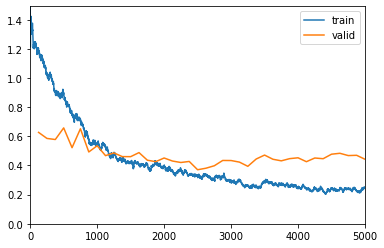

Better model found at epoch 0 with valid_loss value: 0.6272386908531189.
Better model found at epoch 1 with valid_loss value: 0.585756242275238.
Better model found at epoch 2 with valid_loss value: 0.5782334804534912.
Better model found at epoch 4 with valid_loss value: 0.5222092866897583.
Better model found at epoch 6 with valid_loss value: 0.4928527772426605.
Better model found at epoch 8 with valid_loss value: 0.46754491329193115.
Better model found at epoch 10 with valid_loss value: 0.46106064319610596.
Better model found at epoch 11 with valid_loss value: 0.46060866117477417.
Better model found at epoch 13 with valid_loss value: 0.43619996309280396.
Better model found at epoch 14 with valid_loss value: 0.4263518154621124.
Better model found at epoch 17 with valid_loss value: 0.42060646414756775.
Better model found at epoch 19 with valid_loss value: 0.3708820939064026.


In [90]:
assert not bn.alpha.requires_grad

learn.unfreeze()

assert bn.alpha.requires_grad

random_seed(7,True)
learn.fit_one_cycle(40, wd=1e-06, max_lr=slice(1e-05,1e-03),callbacks = [
    SaveModelCallback(learn=learn),
#     ReduceLROnPlateauCallback(learn=learn)
])

In [91]:
learn.save('40epochs_with_attn')

### Fit like paper

In [29]:
def fit_like_paper(learn, epochs, lr, epochs_to_preserve_lr):
    n_of_batches = len(learn.data.train_dl)
    
    phases = [(TrainingPhase(n_of_batches * (epochs_to_preserve_lr if epochs_to_preserve_lr * i < epochs else epochs % epochs_to_preserve_lr))
                 .schedule_hp('lr', lr / (2**i), anneal=None)) 
              for i in range(math.ceil(epochs/epochs_to_preserve_lr))]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    
#     print(total_epochs)
    learn.fit(epochs, callbacks = [
    SaveModelCallback(learn=learn)])

In [ ]:
assert not bn.alpha.requires_grad

learn.unfreeze()

assert bn.alpha.requires_grad

random_seed(7,True)

paper_epochs = 100
paper_lr = 1e-4
epochs_to_preserve_lr=30
fit_like_paper(learn, paper_epochs, paper_lr,epochs_to_preserve_lr)


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time


In [ ]:
learn.save('with_attn_trained_like_paper_data_aug')

In [98]:
len(learn.data.train_dl) * 2

250

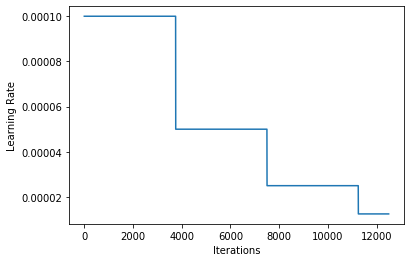

In [181]:
learn.recorder.plot_lr()

In [96]:
learn.alphas.stats.shape

torch.Size([2, 16, 5000])

In [120]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
___________________________________________________

In [97]:
len(learn.data.train_dl)

125

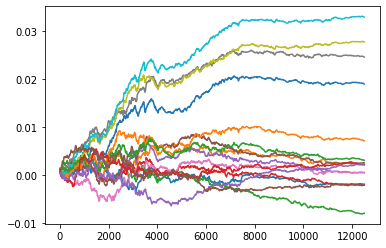

In [137]:
ps = list(learn.model.named_parameters())

ls = [n for n in ps if 'alpha' in n[0]]

for i in range(len(ls)):
    plt.plot(learn.alphas.stats[0][i])

In [138]:
ls[0][1].requires_grad

True

In [139]:
bn = learn.model[0][4][0]

In [91]:
isinstance(bn,nn.Module)

True

In [140]:
[print(n,"\n") for n in ps if 'alpha' in n[0]]

('0.4.0.alpha', Parameter containing:
tensor([-0.0002], device='cuda:0', requires_grad=True)) 

('0.4.1.alpha', Parameter containing:
tensor([0.0059], device='cuda:0', requires_grad=True)) 

('0.4.2.alpha', Parameter containing:
tensor([-0.0003], device='cuda:0', requires_grad=True)) 

('0.5.0.alpha', Parameter containing:
tensor([0.0020], device='cuda:0', requires_grad=True)) 

('0.5.1.alpha', Parameter containing:
tensor([0.0054], device='cuda:0', requires_grad=True)) 

('0.5.2.alpha', Parameter containing:
tensor([0.0082], device='cuda:0', requires_grad=True)) 

('0.5.3.alpha', Parameter containing:
tensor([0.0028], device='cuda:0', requires_grad=True)) 

('0.6.0.alpha', Parameter containing:
tensor([0.0212], device='cuda:0', requires_grad=True)) 

('0.6.1.alpha', Parameter containing:
tensor([0.0209], device='cuda:0', requires_grad=True)) 

('0.6.2.alpha', Parameter containing:
tensor([0.0244], device='cuda:0', requires_grad=True)) 

('0.6.3.alpha', Parameter containing:
tensor([0.

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

# Mish

In [15]:
from fastai.vision import *

import types

from torchvision.models.resnet import Bottleneck

def mish_forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = out * self.mish1gate * torch.tanh(F.softplus(out))

        out = self.conv2(out)
        out = self.bn2(out)
        out = out * self.mish2gate * torch.tanh(F.softplus(out))

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

            
        out = out + identity

        out = out * self.mish3gate * torch.tanh(F.softplus(out))

        return out

def add_mish_to_forward_func(a_module):
    a_module.forward = types.MethodType( mish_forward, a_module)
    
def add_mish_params(a_module):
    print(f'Adding mish to {a_module}')
    a_module.mish1gate = nn.Parameter(torch.ones(1))
    a_module.mish2gate = nn.Parameter(torch.ones(1))
    a_module.mish3gate = nn.Parameter(torch.ones(1))
    del a_module.relu
    
def change_basic_blocks(a_module):
    if not isinstance(a_module, Bottleneck): return
    add_mish_params(a_module)
    add_mish_to_forward_func(a_module)


In [16]:

resnet50_with_mish = models.resnet50(pretrained=True)
apply_leaf(resnet50_with_mish, change_basic_blocks)


Adding mish to Bottleneck(
  (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Adding mish to Bottleneck(
  (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(

In [17]:
a = list(resnet50_with_mish.modules())[0]

In [18]:
bn = a.layer1[0]

In [19]:
bn.mish1gate

Parameter containing:
tensor([1.], requires_grad=True)

In [20]:
ps = list(resnet50_with_mish.named_parameters())

In [21]:
def mock_arch_init_with_mish(params): 
  return resnet50_with_mish

In [22]:
random_seed(7,True)
# x50 = lambda x: xresnet50()resnet14
learn = cnn_learner(data,mock_arch_init_with_mish, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ], 
                    
                    )

In [168]:
# del learn
# del data

torch.cuda.empty_cache()
gc.collect()

4871

In [169]:
# learn.load('bestmodel')
# learn.lr_find()

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.034770,0.907279,0.286667,0.713333,0.515556,00:22
1,0.674582,0.569539,0.206667,0.793333,0.621667,00:22
2,0.570364,0.529503,0.206667,0.793333,0.635833,00:22
3,0.492822,0.457699,0.180000,0.820000,0.745000,00:21
4,0.453891,0.440586,0.186667,0.813333,0.751944,00:21


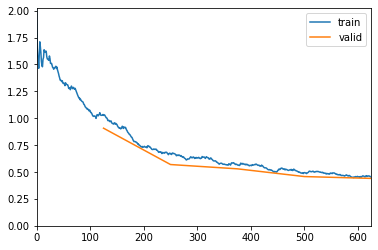

Better model found at epoch 0 with valid_loss value: 0.9072790741920471.
Better model found at epoch 1 with valid_loss value: 0.5695388913154602.
Better model found at epoch 2 with valid_loss value: 0.5295027494430542.
Better model found at epoch 3 with valid_loss value: 0.4576985239982605.
Better model found at epoch 4 with valid_loss value: 0.44058552384376526.


In [170]:
random_seed(7,True)
learn.fit_one_cycle(5,max_lr=3e-3, callbacks = [
    SaveModelCallback(learn=learn),
#     ReduceLROnPlateauCallback(learn=learn)
])

In [171]:
learn.save('stage-1-with-mish')

In [ ]:
learn.load('stage-1-with-mish')

In [24]:
a = list(resnet50_with_mish.modules())[0]

bn = a.layer1[0]

In [25]:
assert not bn.mish1gate.requires_grad

In [26]:
learn.unfreeze()

In [27]:
assert bn.mish1gate.requires_grad

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.390454,0.443938,0.173333,0.826667,0.765833,00:30
1,0.306508,0.493680,0.213333,0.786667,0.703889,00:27
2,0.277540,0.660648,0.226667,0.773333,0.641111,00:27
3,0.376120,0.552073,0.186667,0.813333,0.708333,00:27
4,0.470883,0.537421,0.206667,0.793333,0.710833,00:28
5,0.476074,0.458558,0.180000,0.820000,0.761945,00:27
6,0.437211,0.487816,0.166667,0.833333,0.741667,00:27
7,0.451340,0.443960,0.180000,0.820000,0.769167,00:28
8,0.410526,0.445640,0.180000,0.820000,0.780278,00:28
9,0.419920,0.432835,0.180000,0.820000,0.784722,00:28


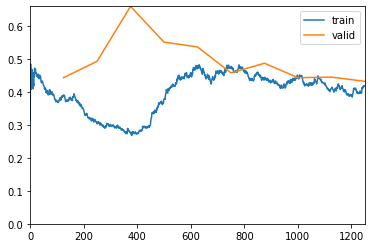

Better model found at epoch 0 with valid_loss value: 0.44393807649612427.
Better model found at epoch 9 with valid_loss value: 0.43283534049987793.


In [28]:
random_seed(7,True)
learn.fit_one_cycle(10, wd=1e-06, max_lr=slice(1e-05,1e-03),callbacks = [
    SaveModelCallback(learn=learn),
#     ReduceLROnPlateauCallback(learn=learn)
])

In [29]:
[print(n,"\n") for n in ps if 'mish' in n[0]]

('layer1.0.mish1gate', Parameter containing:
tensor([1.0001], device='cuda:0', requires_grad=True)) 

('layer1.0.mish2gate', Parameter containing:
tensor([0.9995], device='cuda:0', requires_grad=True)) 

('layer1.0.mish3gate', Parameter containing:
tensor([0.9998], device='cuda:0', requires_grad=True)) 

('layer1.1.mish1gate', Parameter containing:
tensor([1.0002], device='cuda:0', requires_grad=True)) 

('layer1.1.mish2gate', Parameter containing:
tensor([0.9998], device='cuda:0', requires_grad=True)) 

('layer1.1.mish3gate', Parameter containing:
tensor([1.0000], device='cuda:0', requires_grad=True)) 

('layer1.2.mish1gate', Parameter containing:
tensor([1.0002], device='cuda:0', requires_grad=True)) 

('layer1.2.mish2gate', Parameter containing:
tensor([1.0002], device='cuda:0', requires_grad=True)) 

('layer1.2.mish3gate', Parameter containing:
tensor([0.9993], device='cuda:0', requires_grad=True)) 

('layer2.0.mish1gate', Parameter containing:
tensor([1.0003], device='cuda:0', req

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

# Testing

In [18]:
learn.load("auroc_"+ model_name)

Learner(data=ImageDataBunch;

Train: LabelList (2000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
other,other,other,other,other
Path: 2017/data;

Valid: LabelList (150 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
other,other,other,melanoma,other
Path: 2017/data;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
 

In [22]:
learn.data.train_ds[0]

(Image (3, 224, 224), Category other)

In [67]:
random_seed(42,True)
tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.6, max_lighting=.3,p_affine=1,max_warp=0.2)

data_test = ImageList.from_folder(path_test_images)\
.split_none()\
.label_from_func(get_label_for_image_path)\
.transform([[],[]], size=224)\
.databunch(bs=32)\
.normalize()

In [ ]:
data_test.show_batch()

In [ ]:
assert len(data_test.train_dl.y.items) == 600

In [68]:
learn.data.valid_dl = data_test.train_dl

In [69]:
learn.validate(metrics=[accuracy, AUROC()])

[0.6149181, tensor(0.7847), tensor(0.8072)]

In [70]:
learn.validate(metrics=[accuracy, AUROC()])

[0.61665887, tensor(0.7882), tensor(0.8068)]

In [ ]:
learn.data.valid_ds[0][0]